# DATA ANALYSIS

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk.sentiment.vader as vd
from nltk.tokenize import word_tokenize

In [2]:
with open("serialized/data.pkl", "rb") as f:
    data = pickle.load(f)

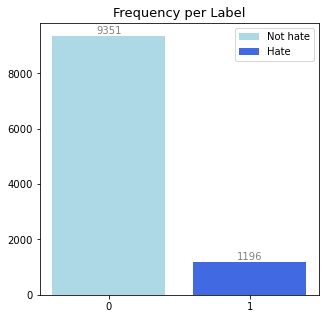

In [3]:
fig, ax = plt.subplots(figsize=(5,5))
labels = data["label"].value_counts().values
rects1 = ax.bar("0", data["label"].value_counts().values[0], color=['lightblue'], label='Not hate')
rects2 = ax.bar("1", data["label"].value_counts().values[1], color=[ 'royalblue'], label='Hate')
rects = ax.patches
ax.legend()
#ax.tick_params(axis='both', colors='grey')
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')#.set_color("grey")
plt.title('Frequency per Label', fontsize = 13)#.set_color("grey")
fig.savefig("images_d\Freq_labels.png")

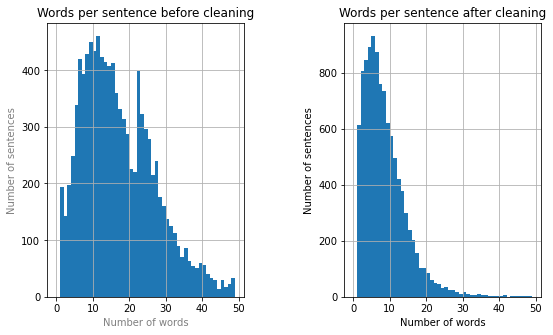

In [4]:
fig = plt.figure()
ax = plt.subplot(1,2,1)
#plt.figure(figsize=(10,5))
plt.hist(data.word_count_before.values, bins = range(0, 50))
plt.title('Words per sentence before cleaning')#.set_color("grey")
plt.xlabel("Number of words")#.set_color("grey")
plt.ylabel("Number of sentences")#.set_color("grey")
#ax.tick_params(axis='both', colors='grey')
plt.grid(True)

ax = plt.subplot(1,2,2)
plt.hist(data.word_count.values, bins = range(0, 50))
plt.title('Words per sentence after cleaning')#.set_color("grey")
plt.xlabel("Number of words")#.set_color("grey")
plt.ylabel("Number of sentences") #.set_color("grey")
#ax.tick_params(axis='both', colors='grey')
plt.grid(True)

plt.tight_layout(w_pad=3.5, h_pad=1.0)
fig.set_figheight(5)
fig.set_figwidth(8)
fig.savefig("images_d\Words_before_after.png")
plt.show()

## 2. Bow and Tfidf

In [5]:
# Bow vectorizer
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(data['lemmatized'])

In [6]:
# Tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(data['lemmatized'])

In [7]:
Xa = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names())
dictionary = ['white', 'black', 'kill', 'kid', 'school','student']
A = Xa[dictionary]
first = A.loc[10:11]
second = A.loc[17:18]
third = A.loc[21:24]
frames = [first, second, third]
result = pd.concat(frames)
result

,white,black,kill,kid,school,student
10,0.121065,0.154474,0.215416,0.000000,0.000000,0.000000
11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17,0.301538,0.000000,0.000000,0.000000,0.000000,0.000000
18,0.150519,0.000000,0.000000,0.000000,0.000000,0.000000
21,0.000000,0.000000,0.000000,0.212203,0.000000,0.000000
22,0.232759,0.000000,0.000000,0.000000,0.331963,0.450354
23,0.000000,0.000000,0.000000,0.363792,0.000000,0.000000
24,0.000000,0.000000,0.000000,0.000000,0.000000,0.215986


## 3. Top words

In [8]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [9]:
common_words = get_top_n_words(data['lemmatized'], 50)
cmw = {word: freq for word, freq in common_words}

In [10]:
mcw = pd.DataFrame.from_dict(cmw, orient='index').reset_index()
mcw.columns = ["words", "freq"]
mcw[:20]

,words,freq
0,white,1431
1,get,801
2,like,796
3,go,699
4,people,614
5,see,606
6,pron,605
7,black,582
8,one,550
9,would,517


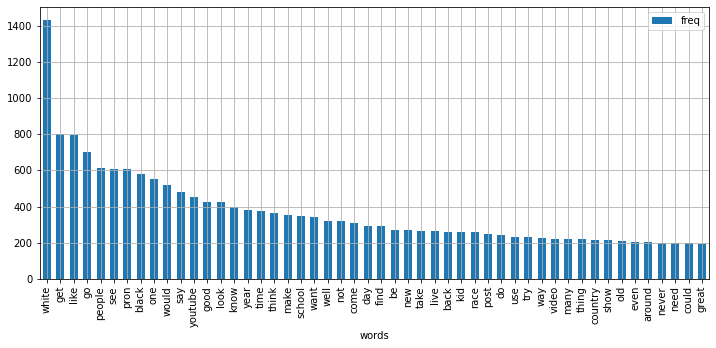

In [11]:
mcw.plot(x="words", y="freq", kind="bar", figsize=(12,5), width=0.6)
plt.grid(True)
plt.savefig("images_d\Top20_words.png")
plt.show()

## 3.1 Part of Speech

In [12]:
all_pos = data['POS_spacy'].sum()

In [13]:
all_adjs = [x[0] for x in all_pos if x[1] == "ADJ"]
all_nouns = [x[0] for x in all_pos if x[1] == "NOUN"]
all_propn = [x[0] for x in all_pos if x[1] == "PROPN"]

In [14]:
hate = data.loc[data["label"] == 1]

In [15]:
all_pos_hate = hate['POS_spacy'].sum()

In [16]:
all_adjs_hate = [x[0] for x in all_pos_hate if x[1] == "ADJ"]
all_nouns_hate = [x[0] for x in all_pos_hate if x[1] == "NOUN"]
all_propn_hate = [x[0] for x in all_pos_hate if x[1] == "PROPN"]

## 3.2 Top POS

In [17]:
pos_counter = {}
for x in all_pos:
    if x[1] in pos_counter:
        pos_counter[x[1]] += 1
    else:
        pos_counter[x[1]] = 1
        
top_pos = {k: v for k, v in sorted(pos_counter.items(), key=lambda item: item[1], reverse=True)}

In [18]:
freq_pos = pd.DataFrame.from_dict(top_pos, orient="index", columns=["Freq"]).reset_index()
freq_pos["R_Freq"] = freq_pos.apply(lambda x: np.round(x.Freq / freq_pos.Freq.sum(), 2), axis=1)

In [19]:
pos_counter_hate = {}
for x in all_pos_hate:
    if x[1] in pos_counter_hate:
        pos_counter_hate[x[1]] += 1
    else:
        pos_counter_hate[x[1]] = 1
        
top_pos_hate = {k: v for k, v in sorted(pos_counter_hate.items(), key=lambda item: item[1], reverse=True)}

In [20]:
freq_pos_hate = pd.DataFrame.from_dict(top_pos_hate, orient="index", columns=["Freq"]).reset_index()
freq_pos_hate["R_Freq"] = freq_pos_hate.apply(lambda x: np.round(x.Freq / freq_pos_hate.Freq.sum(), 2), axis=1)

In [21]:
compared_pos = {"Total": list(top_pos.keys())[:len(top_pos_hate)], "Freq_Total": list(top_pos.values())[:len(top_pos_hate)], "Hate_Speech": top_pos_hate.keys(), "Freq_Hate": top_pos_hate.values()}
compared_pos = pd.DataFrame(compared_pos)
compared_pos["R_Freq_Total"] = compared_pos.apply(lambda x: np.round(x.Freq_Total / compared_pos.Freq_Total.sum(), 3), axis=1)
compared_pos["R_Freq_Hate"] = compared_pos.apply(lambda x: np.round(x.Freq_Hate / compared_pos.Freq_Hate.sum(), 3), axis=1)
compared_pos = compared_pos.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
compared_pos

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,NOUN,0.311,NOUN,0.321
1,VERB,0.221,VERB,0.237
2,PROPN,0.203,PROPN,0.173
3,ADJ,0.129,ADJ,0.141
4,ADV,0.059,ADV,0.061
5,PRON,0.017,PRON,0.016
6,INTJ,0.011,SCONJ,0.012
7,SCONJ,0.011,INTJ,0.008
8,NUM,0.009,NUM,0.007
9,ADP,0.008,ADP,0.007


## 3.3 Top Adjectives

In [22]:
adj_counter = {}
for word in all_adjs:
    if word in adj_counter:
        adj_counter[word] += 1
    else:
        adj_counter[word] = 1

top_20_adj = {k: v for k, v in sorted(adj_counter.items(), key=lambda item: item[1], reverse=True)[:20]}

In [23]:
adj_counter1 = {}
for word in all_adjs_hate:
    if word in adj_counter1:
        adj_counter1[word] += 1
    else:
        adj_counter1[word] = 1
            
top_20_adj1 = {k: v for k, v in sorted(adj_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}

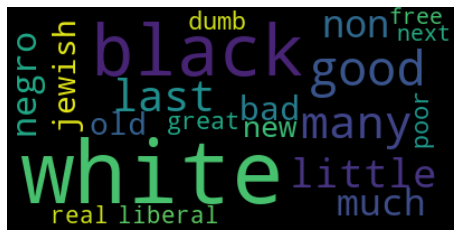

In [24]:
wc_a_hate = WordCloud().generate_from_frequencies(top_20_adj1)
plt.figure(figsize=(8,5))
plt.imshow(wc_a_hate, interpolation="bilinear")
plt.axis("off")
wc_a_hate.to_file("images_d\wc_a_hate.png")
plt.show()

In [25]:
top_adj = {"Total": top_20_adj.keys(), "Freq_Total": top_20_adj.values(), "Hate_Speech": top_20_adj1.keys(), "Freq_Hate": top_20_adj1.values()}
top_adj = pd.DataFrame(top_adj)
top_adj["R_Freq_Total"] = top_adj.apply(lambda x: np.round(x.Freq_Total / top_adj.Freq_Total.sum(), 3), axis=1)
top_adj["R_Freq_Hate"] = top_adj.apply(lambda x: np.round(x.Freq_Hate / top_adj.Freq_Hate.sum(), 3), axis=1)
top_adj = top_adj.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
top_adj

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,white,0.238,white,0.275
1,good,0.101,black,0.166
2,black,0.097,good,0.063
3,many,0.067,many,0.055
4,new,0.057,last,0.049
5,old,0.055,little,0.041
6,last,0.048,non,0.036
7,great,0.045,much,0.034
8,little,0.034,negro,0.033
9,much,0.032,bad,0.028


In [26]:
common_adj = list(set(top_adj["Hate_Speech"].values).intersection(set(top_adj["Total"].values)))

In [27]:
freq_common_tot_adj = [adj_counter[x] for x in common_adj]
freq_common_hate_adj = [adj_counter1[x] for x in common_adj]

In [28]:
common_adj_df = pd.DataFrame({"Adj" : common_adj, "Freq_Tot": freq_common_tot_adj, "Freq_Hate_Speech": freq_common_hate_adj } )
common_adj_df = common_adj_df.sort_values(by = ['Freq_Hate_Speech'], ascending = False, ignore_index=True)

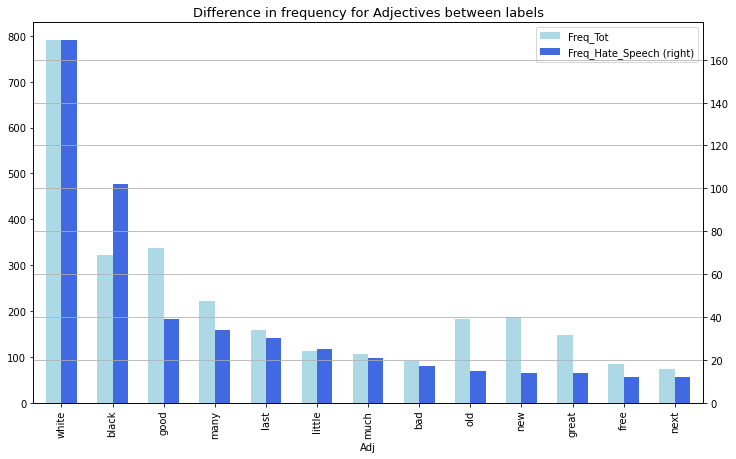

In [29]:
common_adj_df.set_index("Adj").plot(secondary_y=['Freq_Hate_Speech'], kind='bar', color=['lightblue', 'royalblue'], figsize=(12,7), width=0.6)
#plt.tick_params(axis= 'y', colors = 'grey')
plt.grid(True)
plt.title('Difference in frequency for Adjectives between labels', fontsize = 13)#.set_color("grey")
plt.savefig("images_d\Adj_tot_hate.png")
plt.show()

## 3.4 Top Nouns

In [30]:
noun_counter = {}
for word in all_nouns:
    if word in noun_counter:
        noun_counter[word] += 1
    else:
        noun_counter[word] = 1
            
top_20_noun = {k: v for k, v in sorted(noun_counter.items(), key=lambda item: item[1], reverse=True)[:20]}

In [31]:
noun_counter1 = {}
for word in all_nouns_hate:
    if word in noun_counter1:
        noun_counter1[word] += 1
    else:
        noun_counter1[word] = 1
            
top_20_noun1 = {k: v for k, v in sorted(noun_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}

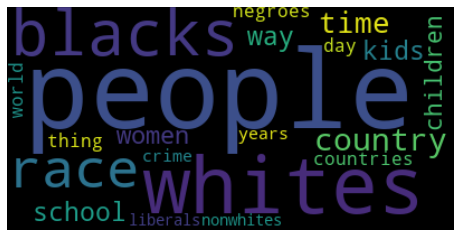

In [32]:
wc_n_hate = WordCloud().generate_from_frequencies(top_20_noun1)
plt.figure(figsize=(8,5))
plt.imshow(wc_n_hate, interpolation="bilinear")
plt.axis("off")
wc_n_hate.to_file("images_d\wc_n_hate.png")
plt.show()

In [33]:
top_noun = {"Total": top_20_noun.keys(), "Freq_Total": top_20_noun.values(), "Hate_Speech": top_20_noun1.keys(), "Freq_Hate": top_20_noun1.values()}
top_noun = pd.DataFrame(top_noun)
top_noun["R_Freq_Total"] = top_noun.apply(lambda x: np.round(x.Freq_Total / top_noun.Freq_Total.sum(), 3), axis=1)
top_noun["R_Freq_Hate"] = top_noun.apply(lambda x: np.round(x.Freq_Hate / top_noun.Freq_Hate.sum(), 3), axis=1)
top_noun = top_noun.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
top_noun

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,people,0.160,people,0.131
1,time,0.070,whites,0.121
2,whites,0.069,blacks,0.096
3,school,0.055,race,0.090
4,race,0.055,country,0.059
5,years,0.053,time,0.051
6,kids,0.053,way,0.041
7,year,0.048,kids,0.039
8,blacks,0.047,school,0.039
9,day,0.045,women,0.037


In [34]:
common_nouns = list(set(top_noun["Hate_Speech"].values).intersection(set(top_noun["Total"].values)))

In [35]:
freq_common_noun_tot = [noun_counter[x] for x in common_nouns]
freq_common_noun_hate = [noun_counter1[x] for x in common_nouns]

In [36]:
common_noun_df = pd.DataFrame({"Nouns" : common_nouns, "Freq_Tot": freq_common_noun_tot, "Freq_Hate_Speech": freq_common_noun_hate })
common_noun_df = common_noun_df.sort_values(by = ['Freq_Hate_Speech'], ascending = False, ignore_index=True)

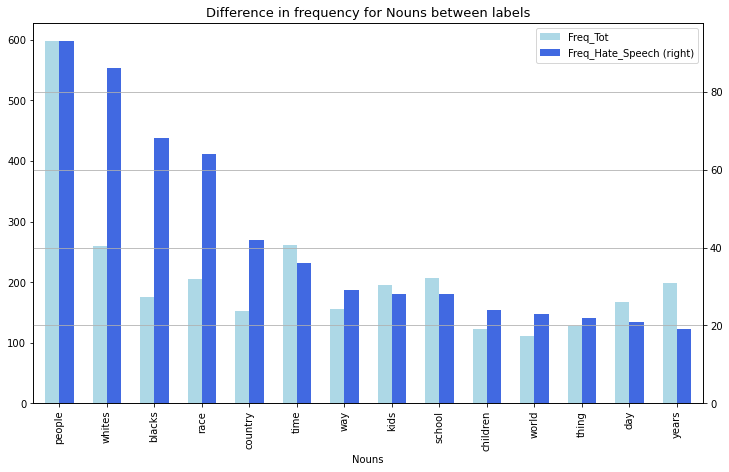

In [37]:
common_noun_df.set_index("Nouns").plot(secondary_y=['Freq_Hate_Speech'], kind='bar', color=['lightblue', 'royalblue'], figsize=(12,7), width=0.6)
#plt.tick_params(axis= 'y', colors = 'grey')
plt.grid(True)
plt.title('Difference in frequency for Nouns between labels', fontsize = 13)#.set_color("grey")
plt.savefig("images_d\ Noun_tot_hate.png")
plt.show()

## 3.5 Top Proper Nouns

In [38]:
propn_counter = {}
for word in all_propn:
    if word in propn_counter:
        propn_counter[word] += 1
    else:
        propn_counter[word] = 1

top_20_propn = {k: v for k, v in sorted(propn_counter.items(), key=lambda item: item[1], reverse=True)[:20]}

In [39]:
propn_counter1 = {}
for word in all_propn_hate:
    if word in propn_counter1:
        propn_counter1[word] += 1
    else:
        propn_counter1[word] = 1
            
top_20_propn1 = {k: v for k, v in sorted(propn_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}

In [40]:
print(type(top_20_adj1))

<class 'dict'>


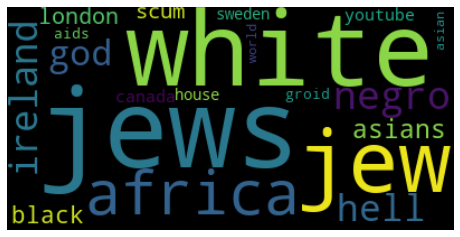

In [41]:
wc_p_hate = WordCloud().generate_from_frequencies(top_20_propn1)
plt.figure(figsize=(8,5))
plt.imshow(wc_p_hate, interpolation="bilinear")
plt.axis("off")
wc_p_hate.to_file("images_d\wc_p_hate.png")
plt.show()

In [42]:
top_propn = {"Total": top_20_propn.keys(), "Freq_Total": top_20_propn.values(), "Hate_Speech": top_20_propn1.keys(), "Freq_Hate": top_20_propn1.values()}
top_propn = pd.DataFrame(top_propn)
top_propn["R_Freq_Total"] = top_propn.apply(lambda x: np.round(x.Freq_Total / top_propn.Freq_Total.sum(), 3), axis=1)
top_propn["R_Freq_Hate"] = top_propn.apply(lambda x: np.round(x.Freq_Hate / top_propn.Freq_Hate.sum(), 3), axis=1)
top_propn = top_propn.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
top_propn

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,white,0.174,jews,0.148
1,youtube,0.169,white,0.142
2,jews,0.063,jew,0.092
3,ireland,0.059,africa,0.072
4,https,0.045,negro,0.059
5,god,0.041,ireland,0.054
6,jew,0.041,hell,0.050
7,new,0.038,god,0.046
8,africa,0.037,asians,0.044
9,black,0.035,black,0.035


In [43]:
common_propn = list(set(top_propn["Hate_Speech"].values).intersection(set(top_propn["Total"].values)))

In [44]:
freq_common_propn_tot = [propn_counter[x] for x in common_propn]
freq_common_propn_hate = [propn_counter1[x] for x in common_propn]

In [45]:
common_propn_df = pd.DataFrame({"Proper Nouns" : common_propn, "Freq_Tot": freq_common_propn_tot, "Freq_Hate_Speech": freq_common_propn_hate })
common_propn_df = common_propn_df.sort_values(by = ['Freq_Hate_Speech'], ascending = False, ignore_index=True)

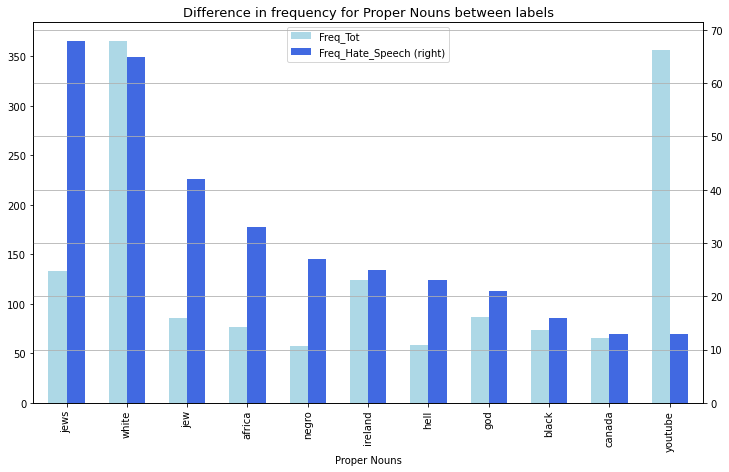

In [46]:
common_propn_df.set_index("Proper Nouns").plot(secondary_y=['Freq_Hate_Speech'], kind='bar', color=['lightblue', 'royalblue'], figsize=(12,7), width=0.6)
#plt.tick_params(axis= 'y', colors = 'grey')
plt.grid(True)
plt.title('Difference in frequency for Proper Nouns between labels', fontsize = 13)#.set_color("grey")
plt.savefig("images_d\Propn_tot_hate.png")
plt.show()

### Cloud of top words

In [47]:
total = {**top_20_adj1 , **top_20_noun1, **top_20_propn1}

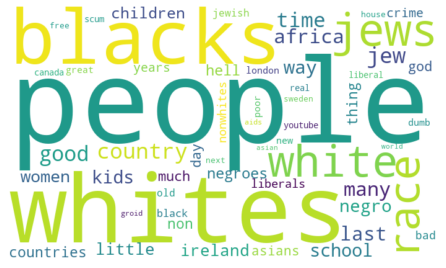

In [48]:
from PIL import Image
from os import path, getcwd
path = "images/cloud2.png"
mask = np.array(Image.open(path))
wordcloud = WordCloud(width=1600, height=800, background_color="rgba(255, 255, 255, 0)", mask=mask).generate_from_frequencies(total)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
wordcloud.to_file("images_d\wc_tot_hate.png")
plt.show()

## 4. Sentiment Analysis by nltk VEDER 

In [49]:
def filter_text_pos(x):
    final_pos_text = []
    for elem in x:
        for pos in pos_list:
            if elem[1] == pos:
                final_pos_text.append(elem[0])
    
    return " ".join(final_pos_text)

In [50]:
sia = vd.SentimentIntensityAnalyzer()
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV",  "DET" ]
data["NOUN_PROPN_VERB_ADJ_ADV_DET"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NOUN_PROPN_VERB_ADJ_ADV_DET'] = data["NOUN_PROPN_VERB_ADJ_ADV_DET"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN_PROPN_VERB_ADJ_ADV_DET']
correl_NOUN_PROPN_VERB_ADJ_ADV_DET = col1.corr(col2)
print(correl_NOUN_PROPN_VERB_ADJ_ADV_DET)

-0.12725489998187178


In [51]:
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV", "ADP", "DET" ]
data["NOUN_PROPN_VERB_ADJ_ADV_ADP_DET"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NOUN_PROPN_VERB_ADJ_ADV_ADP_DET'] = data["NOUN_PROPN_VERB_ADJ_ADV_ADP_DET"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN_PROPN_VERB_ADJ_ADV_ADP_DET']
correl_NOUN_PROPN_VERB_ADJ_ADV_ADP_DET = col1.corr(col2)
print(correl_NOUN_PROPN_VERB_ADJ_ADV_ADP_DET)

-0.1272243647776928


In [52]:
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV" ]
data["NOUN_PROPN_VERB_ADJ_ADV"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NOUN_PROPN_VERB_ADJ_ADV'] = data["NOUN_PROPN_VERB_ADJ_ADV"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN_PROPN_VERB_ADJ_ADV']
correl_NOUN_PROPN_VERB_ADJ_ADV = col1.corr(col2)
print(correl_NOUN_PROPN_VERB_ADJ_ADV)

-0.12698652537868396


In [53]:
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV", "ADP" ]
data["NOUN_PROPN_VERB_ADJ_ADV_ADP"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NOUN_PROPN_VERB_ADJ_ADV_ADP'] = data["NOUN_PROPN_VERB_ADJ_ADV_ADP"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN_PROPN_VERB_ADJ_ADV_ADP']
correl_NOUN_PROPN_VERB_ADJ_ADV_ADP = col1.corr(col2)
print(correl_NOUN_PROPN_VERB_ADJ_ADV_ADP)

-0.12695607548878


In [54]:
data['sentiment_text'] = data["lemmatized"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_text']
correl_text = col1.corr(col2)
print(correl_text)

-0.12078705168234023


In [55]:
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV", "SCONJ"]
data["NOUN_PROPN_VERB_ADJ_ADV_SCONJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NOUN_PROPN_VERB_ADJ_ADV_SCONJ'] = data["NOUN_PROPN_VERB_ADJ_ADV_SCONJ"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN_PROPN_VERB_ADJ_ADV_SCONJ']
correl_NOUN_PROPN_VERB_ADJ_ADV_SCONJ = col1.corr(col2)
print(correl_NOUN_PROPN_VERB_ADJ_ADV_SCONJ)

-0.11907694189566177


In [56]:
pos_list = ["NOUN","PROPN", "ADJ" ]
data["NOUN_PROPN_ADJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NOUN_PROPN_ADJ'] = data["NOUN_PROPN_ADJ"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN_PROPN_ADJ']
correl_NOUN_PROPN_ADJ = col1.corr(col2)
print(correl_NOUN_PROPN_ADJ)

-0.11869343502013532


In [57]:
pos_list = ["NOUN","PROPN", "ADJ", "ADV" ]
data["NOUN_PROPN_ADJ_ADV"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NOUN_PROPN_ADJ_ADV'] = data["NOUN_PROPN_ADJ_ADV"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN_PROPN_ADJ_ADV']
correl_NOUN_PROPN_ADJ_ADV = col1.corr(col2)
print(correl_NOUN_PROPN_ADJ_ADV)

-0.11412001850867753


In [58]:
data['sentiment_ADJ'] = data["ADJ"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_ADJ']
correl_ADJ = col1.corr(col2)
print(correl_ADJ)

-0.08800779041512649


In [59]:
data['sentiment_NOUN'] = data["NOUN"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN']
correl_NOUN = col1.corr(col2)
print(correl_NOUN)

-0.08135546915320589


In [60]:
data['sentiment_VERB'] = data["VERB"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_VERB']
correl_VERB = col1.corr(col2)
print(correl_VERB)

-0.06825751456108617


In [61]:
data['sentiment_PROPN'] = data["PROPN"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_PROPN']
correl_PROPN = col1.corr(col2)
print(correl_PROPN)

-0.04068001247849975


In [62]:
data['sentiment_PRON'] = data["PRON"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_PRON']
correl_PRON = col1.corr(col2)
print(correl_PRON)

-0.003482512451013809


In [63]:
pos_list = ["ADP"]
data["ADP"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_ADP'] = data["ADP"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_ADP']
correl_PROPN = col1.corr(col2)
print(correl_PROPN)

-0.0010373130255039679


In [66]:
data['sentiment_ADV'] = data["ADV"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_ADV']
correl_ADV = col1.corr(col2)
print(correl_ADV)

0.002337835592291898


In [65]:
data['sentiment_SCONJ'] = data["SCONJ"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_SCONJ']
correl_SCONJ = col1.corr(col2)
print(correl_SCONJ)

0.037497792881513635
